Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Accuracy: 0.6538461538461539
Classification Report:
               precision    recall  f1-score   support

         404       0.33      0.29      0.31         7
         410       0.75      0.79      0.77        19

    accuracy                           0.65        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.64      0.65      0.64        26



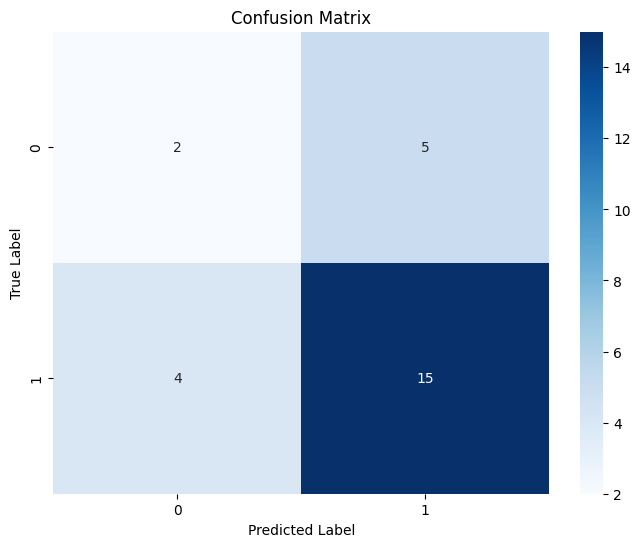

Prediction: [410]
Probabilities: [[0.86103676 0.13896324]]

📄 Extracted Text:
  
  
  

with caution. fi
Height ~s\t
when r a

      



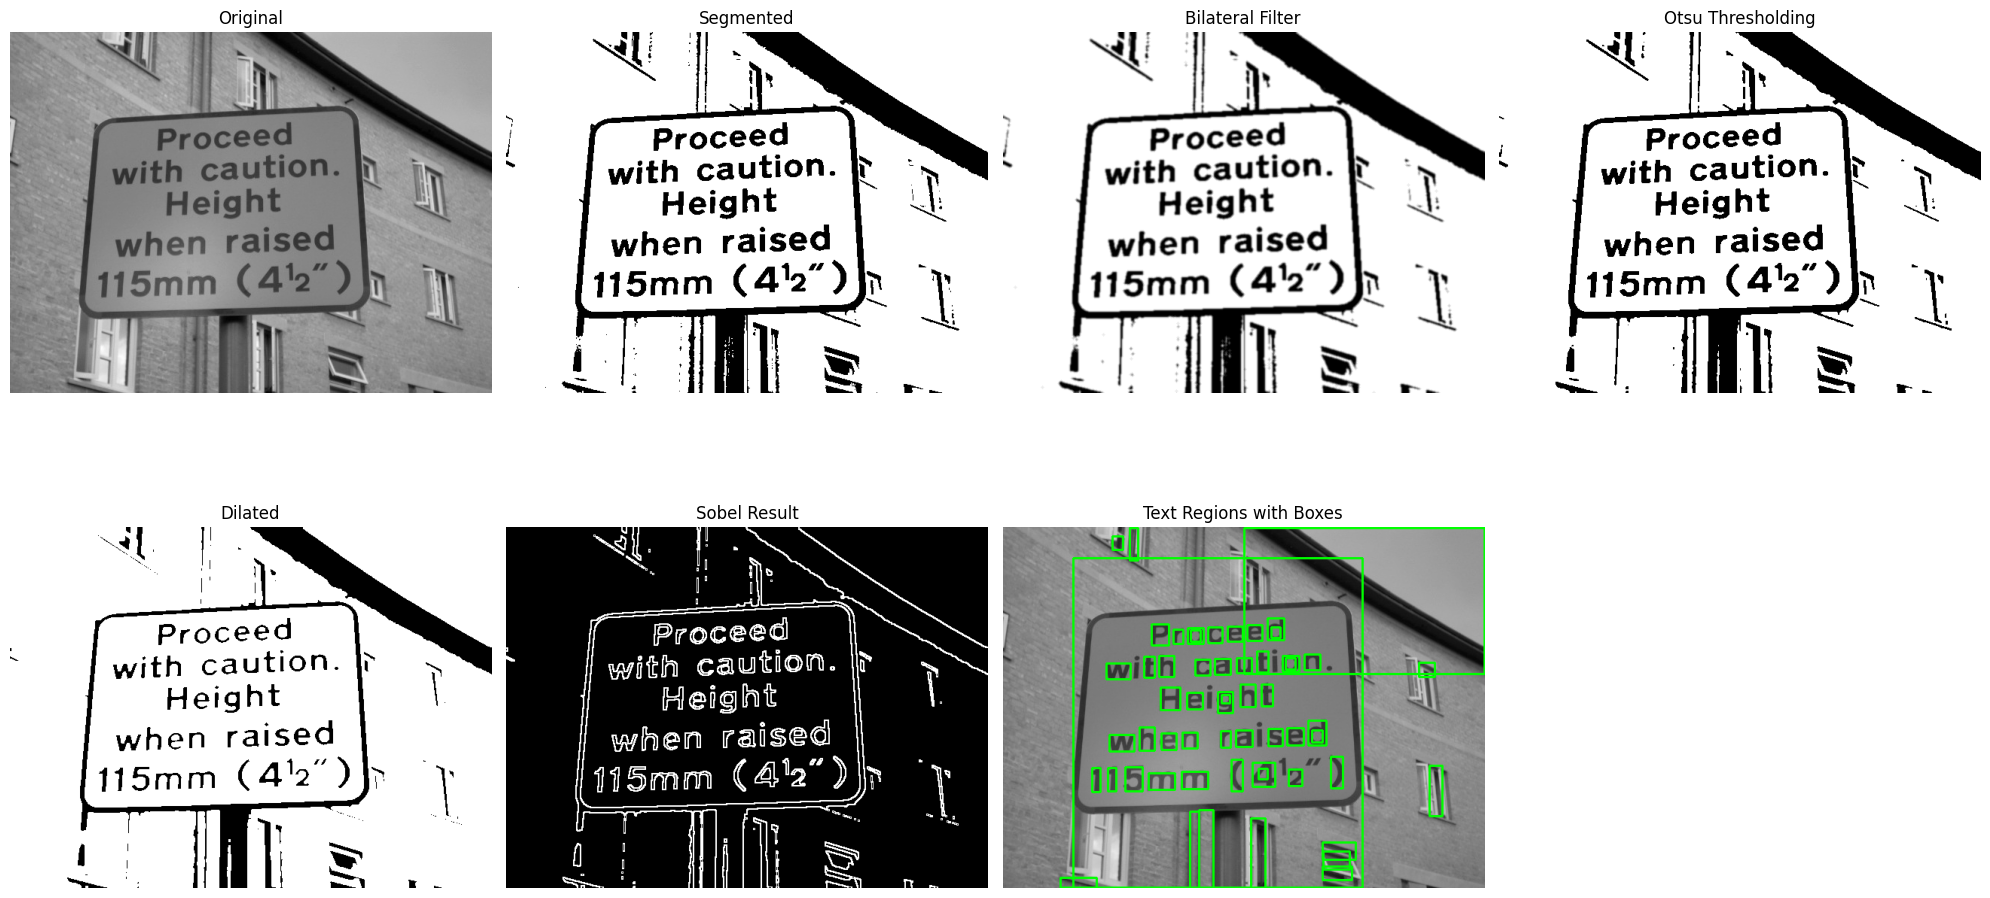

In [ ]:
# ===============================
#  Text Extraction & Classification Pipeline
# ===============================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

!sudo apt install tesseract-ocr -y
!pip install pytesseract

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# ===============================
# Step 1: Feature Extraction
# ===============================
def preprocess_image(image):
    image = cv2.equalizeHist(image)  # Contrast enhancement
    return image

def extract_hog_features(image, win_size=(64, 128)):
    hog = cv2.HOGDescriptor(win_size, (16, 16), (8, 8), (8, 8), 9)
    resized_image = cv2.resize(image, win_size)
    return hog.compute(resized_image)

def load_images_and_extract_features(folder_path, win_size=(64, 128)):
    X, y = [], []
    for class_label in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_label)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = preprocess_image(image)
            hog_features = extract_hog_features(image, win_size).flatten()
            X.append(hog_features)
            y.append(int(class_label))

    return np.array(X), np.array(y)

# ===============================
# Step 2: Load, Scale, PCA, Split
# ===============================
dataset_folder = "/content/drive/MyDrive/minor dataset (ICDAR)"
X, y = load_images_and_extract_features(dataset_folder)
X, y = shuffle(X, y, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# Step 3: Grid Search + Training
# ===============================
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_clf = GridSearchCV(svm.SVC(probability=True), param_grid, cv=5, verbose=1)
svm_clf.fit(X_train, y_train)

print("\n✅ Best Parameters:", svm_clf.best_params_)

# ===============================
# Step 4: Evaluate
# ===============================
y_pred = svm_clf.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===============================
# Step 5: Full Pipeline on Image
# ===============================
image_path = '/content/drive/MyDrive/minor dataset (ICDAR)/410/IMG_2461.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Error loading image. Check path.")

def segment_image(image, k=2):
    pixel_values = image.reshape((-1, 1)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented = centers[labels.flatten()].reshape(image.shape)
    return np.uint8(segmented)

segmented_image = segment_image(image)
bilateral_filter = cv2.bilateralFilter(segmented_image, 5, 125, 105)
_, otsu_result = cv2.threshold(bilateral_filter, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
dilated_image = cv2.dilate(otsu_result, kernel, iterations=1)

# MSER Text Detection
def detect_text_regions(image):
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(image)
    boxes = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
        if w > 10 and h > 10:
            boxes.append((x, y, w, h))
    return boxes

boxes = detect_text_regions(dilated_image)
image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in boxes:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Edge Detection + Prediction
sobel_x = cv2.Sobel(dilated_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(dilated_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
sobel_result = cv2.convertScaleAbs(sobel_magnitude)

hog_features = extract_hog_features(sobel_result).flatten()
hog_features = scaler.transform([hog_features])
hog_features = pca.transform(hog_features)

prediction = svm_clf.predict(hog_features)
prediction_proba = svm_clf.predict_proba(hog_features)

print("Prediction:", prediction)
print("Probabilities:", prediction_proba)

# OCR Extraction
extracted_text = pytesseract.image_to_string(image_with_boxes)
print("\n📄 Extracted Text:\n", extracted_text)

# ===============================
# Step 6: Visualization
# ===============================
def show_images(images, titles):
    plt.figure(figsize=(20, 15))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images = [
    image, segmented_image, bilateral_filter, otsu_result,
    dilated_image, sobel_result, cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
]
titles = [
    "Original", "Segmented", "Bilateral Filter", "Otsu Thresholding",
    "Dilated", "Sobel Result", "Text Regions with Boxes"
]
show_images(images, titles)
